<a href="https://colab.research.google.com/github/Aestivation/DL2025-Labs/blob/main/Deep_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 Notebook



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
!pip install scikeras



In [2]:
from sklearn.datasets import make_classification, load_iris, fetch_california_housing
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from keras import models, layers, callbacks, optimizers
from scikeras.wrappers import KerasClassifier, KerasRegressor


plt.rcParams["figure.figsize"] = (7, 4)  # to make figures larger

In [3]:
# Cell 2: Plot training history (loss & accuracy)

def plot_history(history, title=""):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1) #code in this way cause we want to plot x-axis exactly matches the number of training epochs recorded by Keras, starting at epoch 1 instead of 0
    # and we dont know how many epocs are necessary and early stopping stops at which value

    plt.figure()
    plt.plot(epochs, hist["loss"], label="train loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.show()

    if "accuracy" in hist:
        plt.figure()
        plt.plot(epochs, hist["accuracy"], label="train acc")
        if "val_accuracy" in hist:
            plt.plot(epochs, hist["val_accuracy"], label="val acc")
        plt.title(title + " - Accuracy")
        plt.legend()
        plt.show()


In [4]:
# Cell 3: Create synthetic dataset with > 2 features

X, y = make_classification(
    n_samples=2000, # Fast enough to run with NN and PCA
    n_features=10, # Good number of features for PCA for dimension reduction
    n_informative=6,  # Keep only 6 out of 10 =~ 4 is redundant
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)


X shape: (2000, 10)


In [5]:
# Cell 4: PCA manually (first 2 principal components)

X_centered = X_scaled - X_scaled.mean(axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)

eigvals, eigvecs = np.linalg.eigh(cov_matrix)   # Using Linear Algebra to calculate Covariance matrix, needed for evaluation PCA
idx = eigvals.argsort()[::-1]   # Descending order sorting as we want to see the two biggest eigen values ? first

eigvecs = eigvecs[:, idx]
PC_manual = X_centered @ eigvecs[:, :2]  # Projecting centered dataset along PC1 and PC2

PC_manual[:5]  # To see the first 5 rows


array([[ 4.15914673, -1.65900494],
       [-0.06444974,  0.25279638],
       [ 1.01471041,  1.99771843],
       [ 1.99805074,  1.1334542 ],
       [ 0.13766993, -0.00624238]])

In [6]:
# Cell 5: PCA using sklearn # Fixed number of features

pca = PCA(n_components=2)   # Feature reduction from 10 to 2, while it is directly defined here
PC_sklearn = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_) #Variance for each PCA, meaning each PCA captures how much of the information, structure and variations


Explained variance: [0.22061599 0.19444919]


In [7]:
# Cell 6: PCA to preserve 95% variance  # Fixed number of variance

pca95 = PCA(0.95)
X_pca95 = pca95.fit_transform(X_scaled)

print("Number of components for 95% variance:", pca95.n_components_)


Number of components for 95% variance: 7


In [8]:
# Cell 7: Define a small neural network for classification

def build_classifier(input_dim, lr=0.001, hidden=32):  # lr referes to learning rate
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer=optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]   #for classification problem
    )
    return model


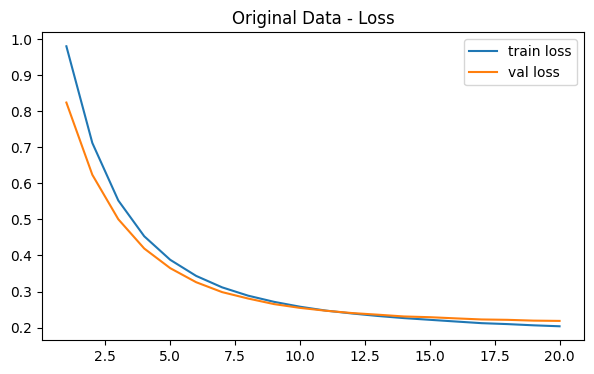

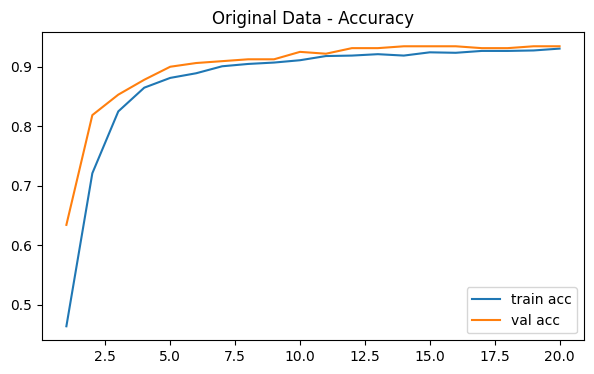

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9267 - loss: 0.2098  


[0.21592003107070923, 0.9075000286102295]

In [9]:
# Cell 8: Train NN on original dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=1
)

model_orig = build_classifier(X_train.shape[1])
hist_orig = model_orig.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    verbose=0  # do not print any thing during training
)

plot_history(hist_orig, "Original Data")
model_orig.evaluate(X_test, y_test)

# loss is soft, showing training was soft. Both loss and accuracy are close, showing not overtraining


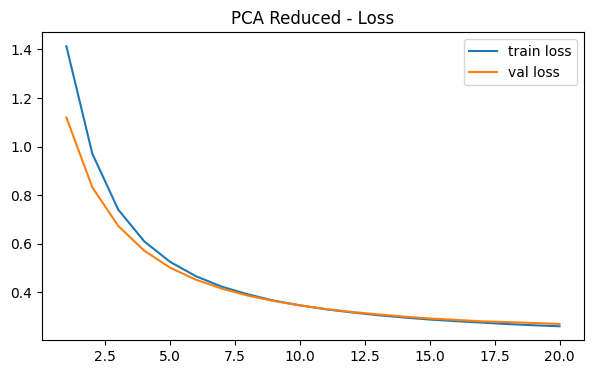

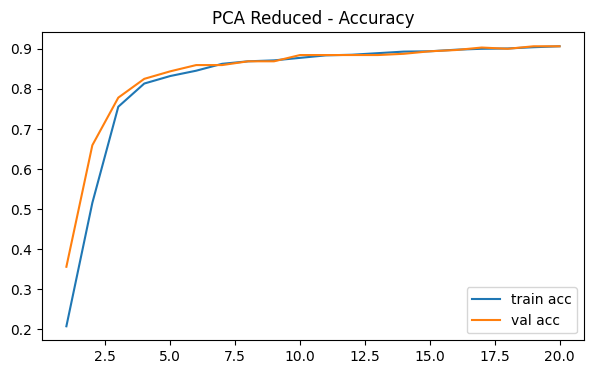

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8968 - loss: 0.2754  


[0.2674201726913452, 0.9024999737739563]

In [10]:
# Cell 9: Train NN on PCA-reduced dataset (95% variance)

X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_pca95, y, test_size=0.2, random_state=1
)

model_pca = build_classifier(X_train_p.shape[1])
hist_pca = model_pca.fit(
    X_train_p, y_train,
    epochs=20,
    validation_split=0.2,
    verbose=0
)

plot_history(hist_pca, "PCA Reduced")
model_pca.evaluate(X_test_p, y_test)
#PCA-Reduced dataset gives a bit less accurate result, we expect loss starts from lower value as the reduced dataset has less noise but i cannot see any difference?????


In [11]:
kernels = ["linear", "sigmoid", "rbf"]   #How different kernels impact CNN rsults Linear kernel just capture linear pattern in the dataset
kpca_results = {}

for k in kernels:
    kpca = KernelPCA(n_components=5, kernel=k, fit_inverse_transform=False)
    X_k = kpca.fit_transform(X_scaled)

    Xk_train, Xk_test, yk_train, yk_test = train_test_split(
        X_k, y, test_size=0.2, random_state=1
    )

    model_k = build_classifier(Xk_train.shape[1])
    hist_k = model_k.fit(
        Xk_train, yk_train,
        epochs=15,
        validation_split=0.2,
        verbose=0
    )

    acc = model_k.evaluate(Xk_test, yk_test, verbose=0)[1]
    kpca_results[k] = acc
    print(f"Kernel={k}, accuracy={acc:.4f}")
    #Linear results better cause the structure is mainly linear


Kernel=linear, accuracy=0.8225
Kernel=sigmoid, accuracy=0.7975
Kernel=rbf, accuracy=0.7650


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("kpca", KernelPCA()),
    ("logreg", LogisticRegression(max_iter=2000))
])

param_grid = {
    "kpca__kernel": ["linear", "rbf", "sigmoid"],
    "kpca__n_components": [3, 5, 7],
    "logreg__C": [0.1, 1, 10]
}

gs = GridSearchCV(pipe, param_grid, cv=3, verbose=2)
gs.fit(X_scaled, y)

print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)

# Best params: {'kpca__kernel': 'rbf', 'kpca__n_components': 7, 'logreg__C': 1}
# Best score: 0.8235064149606878


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=0.1; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=0.1; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=0.1; total time=   0.2s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=1; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=1; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=1; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=10; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=10; total time=   0.1s
[CV] END kpca__kernel=linear, kpca__n_components=3, logreg__C=10; total time=   0.2s
[CV] END kpca__kernel=linear, kpca__n_components=5, logreg__C=0.1; total time=   0.2s
[CV] END kpca__kernel=linear, kpca__n_components=5, logreg__C=0.1; total time=   0.2s
[C


--- Fold 1 ---
Val acc: 1.0000, Val loss: 0.1063

--- Fold 2 ---
Val acc: 1.0000, Val loss: 0.0529

--- Fold 3 ---
Val acc: 0.9667, Val loss: 0.0978

--- Fold 4 ---
Val acc: 1.0000, Val loss: 0.0694

--- Fold 5 ---
Val acc: 0.9333, Val loss: 0.1489

Stratified CV accuracy: 0.9800 ± 0.0267


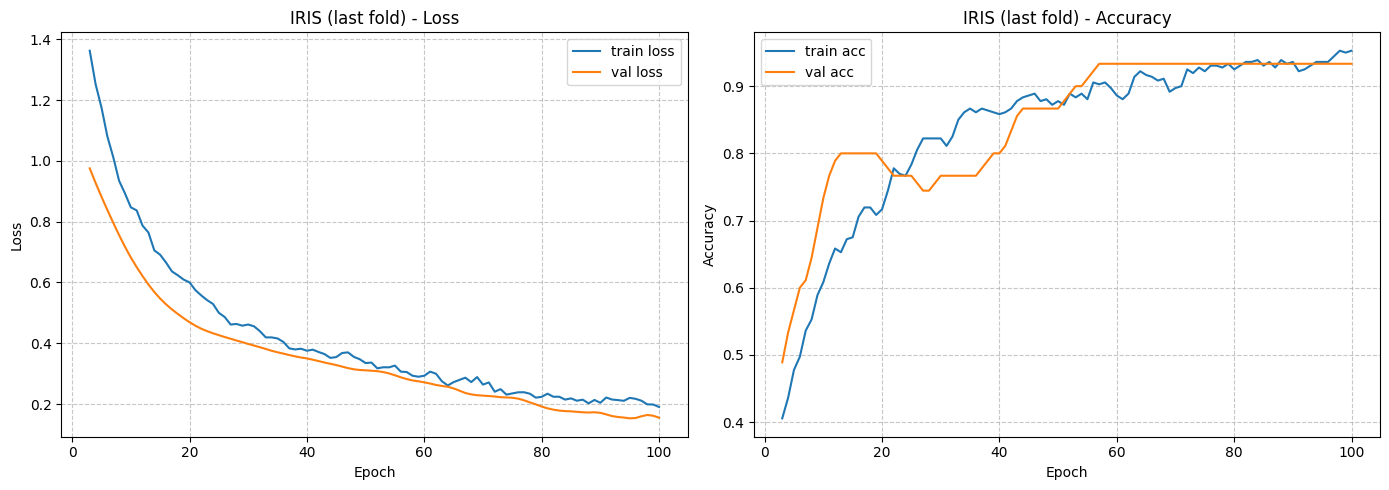


Final test accuracy (hold-out): 0.9667


In [17]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import random as tf_random
from tensorflow.keras import models, layers, optimizers, callbacks, regularizers
import pandas as pd # Import pandas for rolling mean

RND = 1
tf_random.set_seed(RND)
np.random.seed(RND)

# Load and scale
iris = load_iris()
X = iris.data
y = iris.target
sc = StandardScaler()
X = sc.fit_transform(X)

# Model factory (small + regularized)
def make_model(lr=1e-3, hidden=8, l2=1e-3, dropout=0.25):
    m = models.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(hidden, activation="relu",
                     kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(3, activation="softmax")
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# Callbacks used for each fold
def get_callbacks():
    return [
        callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=0)
    ]

# Stratified K-Fold evaluation (k=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
fold_scores = []
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = make_model(lr=1e-3, hidden=8, l2=1e-3, dropout=0.25)
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=8,
        callbacks=get_callbacks(),
        verbose=0
    )
    # store history (optional)
    histories.append(hist)
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Val acc: {acc:.4f}, Val loss: {loss:.4f}")
    fold_scores.append(acc)

mean_acc = np.mean(fold_scores)
std_acc  = np.std(fold_scores)
print(f"\nStratified CV accuracy: {mean_acc:.4f} \u00b1 {std_acc:.4f}")

# Plot the last fold's history in one row with subplots
# Get the history object from the last fold
last_fold_history_obj = histories[-1]
last_fold_hist_data = last_fold_history_obj.history
epochs_last_fold = range(1, len(last_fold_hist_data["loss"]) + 1)

# Define smoothing window size
smoothing_window = 3 # Adjust this value as needed

# Create a single figure with two subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # 1 row, 2 columns

# Plot Loss on the first subplot
axes[0].plot(epochs_last_fold, pd.Series(last_fold_hist_data["loss"]).rolling(window=smoothing_window).mean(), label="train loss")
if "val_loss" in last_fold_hist_data:
    axes[0].plot(epochs_last_fold, pd.Series(last_fold_hist_data["val_loss"]).rolling(window=smoothing_window).mean(), label="val loss")
axes[0].set_title(f"IRIS (last fold) - Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot Accuracy on the second subplot (if available)
if "accuracy" in last_fold_hist_data:
    axes[1].plot(epochs_last_fold, pd.Series(last_fold_hist_data["accuracy"]).rolling(window=smoothing_window).mean(), label="train acc")
    if "val_accuracy" in last_fold_hist_data:
        axes[1].plot(epochs_last_fold, pd.Series(last_fold_hist_data["val_accuracy"]).rolling(window=smoothing_window).mean(), label="val acc")
    axes[1].set_title(f"IRIS (last fold) - Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.savefig("iris_last_fold_history.png", dpi=300, bbox_inches='tight') # Save the combined figure
plt.show() # Display the combined figure

# Final train on full training set and evaluate on a held-out test split (optional)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)
final_model = make_model(lr=1e-3, hidden=8, l2=1e-3, dropout=0.25)
final_model.fit(X_tr, y_tr, validation_split=0.2, epochs=100, batch_size=8,
                callbacks=get_callbacks(), verbose=0)
loss, acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal test accuracy (hold-out): {acc:.4f}")

![IRIS Last Fold History](iris_last_fold_history.png)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 310ms/step - accuracy: 0.6689 - loss: 0.9327 - val_accuracy: 0.1037 - val_loss: 7.4482 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 138s 369ms/step - accuracy: 0.8395 - loss: 0.4414 - val_accuracy: 0.8494 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 115s 306ms/step - accuracy: 0.8663 - loss: 0.3643 - val_accuracy: 0.8568 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 115s 306ms/step - accuracy: 0.8745 - loss: 0.3436 - val_accuracy: 0.8737 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 112s 299ms/step - accuracy: 0.8847 - loss: 0.3133 - val_accuracy: 0.8845 - val_loss: 0.3182 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 112s 300ms/step - accuracy: 0.8889 - loss: 0.3075 - val_accuracy: 0.8472 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 113s 302ms/step - accuracy: 0.8904 

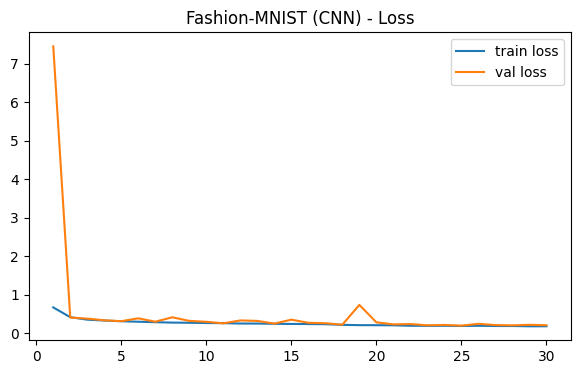

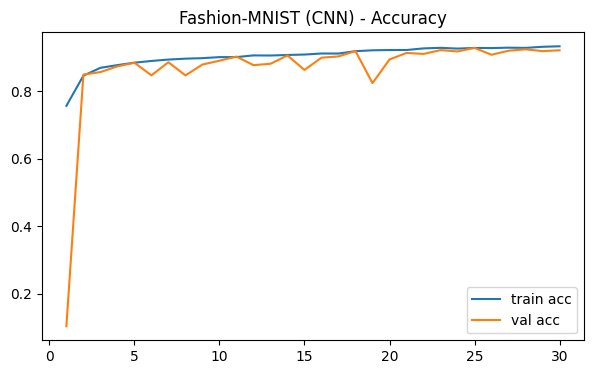

Test accuracy (CNN + aug): 0.9138  — expected ~0.91–0.95 depending on seeds


In [22]:
# Improved Fashion-MNIST training: small CNN + augmentation + callbacks
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 1) Load & preprocess (keep as 28x28x1 images)
(Xf_train, yf_train), (Xf_test, yf_test) = fashion_mnist.load_data()
Xf_train = Xf_train.astype("float32") / 255.0
Xf_test  = Xf_test.astype("float32")  / 255.0
Xf_train = np.expand_dims(Xf_train, -1)   # shape (N,28,28,1)
Xf_test  = np.expand_dims(Xf_test, -1)

# 2) Data augmentation (simple, effective)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=False,   # dataset items are clothing; horizontal flip sometimes okay
    fill_mode='nearest',
    validation_split=0.2      # use 20% of training as val via flow(...)
)

# 3) Build a small CNN
def build_cnn(input_shape=(28,28,1), lr=1e-3):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(10, activation='softmax')
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

# 4) Callbacks
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

model = build_cnn()

# 5) Prepare generators
batch_size = 128
train_gen = datagen.flow(Xf_train, yf_train, batch_size=batch_size, subset='training')
val_gen   = datagen.flow(Xf_train, yf_train, batch_size=batch_size, subset='validation')

# 6) Fit (use steps_per_epoch from training generator)
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=cb,
    verbose=1
)

# 7) Plot history (your plot_history function can be reused)
plot_history(history, "Fashion-MNIST (CNN)")

# 8) Final evaluation
loss, acc = model.evaluate(Xf_test, yf_test, verbose=0)
print(f"Test accuracy (CNN + aug): {acc:.4f}  — expected ~0.91–0.95 depending on seeds")




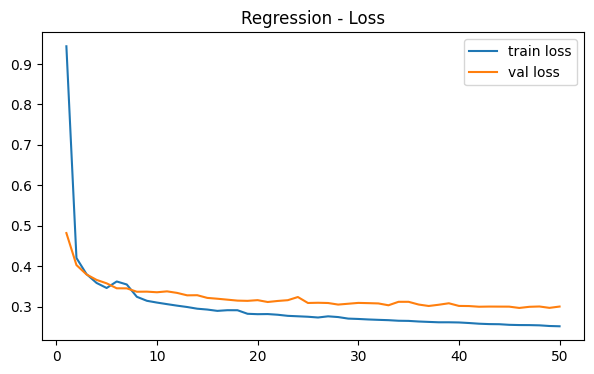

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2937


0.29005783796310425

In [23]:
cal = fetch_california_housing()
Xc, yc = cal.data, cal.target

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=1)

sc_c = StandardScaler()
Xc_train_s = sc_c.fit_transform(Xc_train)
Xc_test_s = sc_c.transform(Xc_test)

def build_regressor(lr=0.001):
    model = models.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=optimizers.Adam(lr), loss="mse")
    return model

reg_model = build_regressor()
reg_hist = reg_model.fit(
    Xc_train_s, yc_train,
    validation_split=0.2,
    epochs=50,
    verbose=0
)

plot_history(reg_hist, "Regression")
reg_model.evaluate(Xc_test_s, yc_test)



LR = 0.001


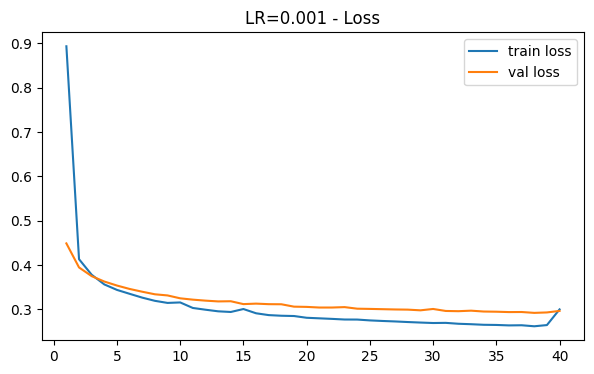

RMSE: 0.5433904259130664

LR = 0.0001


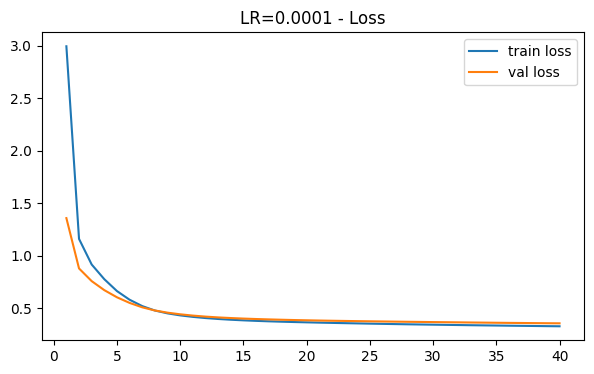

RMSE: 0.5907035775366418


In [24]:
for lr in [0.001, 0.0001]:
    print("\nLR =", lr)
    model_lr = build_regressor(lr=lr)
    hist_lr = model_lr.fit(
        Xc_train_s, yc_train,
        validation_split=0.2,
        epochs=40,
        verbose=0
    )
    plot_history(hist_lr, f"LR={lr}")
    print("RMSE:", np.sqrt(model_lr.evaluate(Xc_test_s, yc_test, verbose=0)))
